# Regresja jednej zmiennej

Plik `fires_thefts.txt` zawiera rzeczywiste dane zebrane przez _U.S. Commission on Civil Rights_, przedstawiające liczbę pożarów w danej dzielnicy na tysiąc gospodarstw domowych (pierwsza kolumna) oraz liczbę włamań w tej samej dzielnicy na tysiąc mieszkańców (druga kolumna). Celem jest stworzenie modelu przewidującego liczbę włamań na podstawie liczby pożarów.

## Zadania

Uruchom notatnik `slides/03/cls03-regresja_liniowa.ipynb`, szczegółowo przeanalizuj kod związany z regresją, a następnie wykonaj poniższe polecenia. Zadania należy wykonać w niniejszym notatniku, prezentacja wyników powinna być czytelna. 

1. Stwórz wykres punktowy dla danych z pliku `fires_thefts.txt`. Zwróć uwagę na poprawne oznaczenia osi, dodaj legendę. Następnie dodaj dowolną prostą z ręcznie dobranymi parametrami $\theta$, oblicz i wyświetl wartość jej błędu $J(\theta)$.
2. Oblicz parametry $\theta$ krzywej regresyjnej za pomocą macierzy normalnej. Otrzymane wyniki przedstaw na nowym wykresie.
3. Oblicz parametry $\theta$ krzywej regresyjnej za pomocą metody gradientu prostego (_Gradient Descent, GD_). Otrzymane wyniki przedstaw na nowym wykresie. Można wybrać wersję iteracyjną lub macierzową algorytmu GD.
4. Dla różnych wartości długości kroku $\alpha \in \{ 0.001, 0.01 , 0.1 \}$ stwórz wykres, który zilustruje progresję wartości $J(\theta)$ dla pierwszych 200 króków algorytmu GD. Wykres ma zatem na osi $x$ kroki od 0 do 200, na osi $y$ wartosci $J(\theta)$, oraz przedstawia trzy krzywe, po jednej dla każdej wartości $\alpha$.
5. Wykorzystując uzyskaną krzywą regresyjną przepowiedz liczbę włamań na 1000 mieszkańców dla dzielnicy, w której występuje średnio 50, 100, 200 pożarów na tysiąc gospodarstw domowych.

In [1]:
# importy

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as pl
import ipywidgets as widgets
from ipywidgets import fixed

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.display import display, Math, Latex
import csv

In [2]:
#rysowanie krzywych regresyjnych i punktów

def regdots(x, y):    
    fig = pl.figure(figsize=(16*.6,9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter(x, y, c='r', s=80, label="Dane")
    
    ax.set_xlabel(r'$Liczba \, pożarów$')
    ax.set_ylabel(r'$Liczba \, włamań$')
    ax.margins(.05,.05)
    pl.ylim(min(y)-1, max(y)+1)
    pl.xlim(min(x)-1, max(x)+1)
    return fig

def regline(fig, fun, theta, x):
    ax = fig.axes[0]
    x0, x1 = min(x), max(x)
    X = [x0, x1]
    Y = [fun(theta, x) for x in X]
    ax.plot(X, Y, linewidth='2', 
            label=(r'$y=%.2f+%.2f x$' % (theta[0], theta[1])))

def legend(fig):
    ax = fig.axes[0]
    handles, labels = ax.get_legend_handles_labels()
    # try-except block is a fix for a bug in Poly3DCollection
    try:
        fig.legend(handles, labels, fontsize='15', loc='lower right')
    except AttributeError:
        pass
    
def regdotsMx(X, y):    
    fig = pl.figure(figsize=(16*.6,9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter(X[:,1], y, c='r', s=80, label="Dane")
    
    ax.set_xlabel(r'$Liczba \, pożarów$')
    ax.set_ylabel(r'$Liczba \, włamań$')
    ax.margins(.05,.05)
    pl.ylim(y.min()-1, y.max()+1)
    pl.xlim(np.min(X[:,1])-1, np.max(X[:,1])+1)
    return fig

def reglineMx(fig, fun, theta, X):
    ax = fig.axes[0]
    x0, x1 = np.min(X[:,1]), np.max(X[:,1])
    L = [x0, x1]
    LX = np.matrix([1, x0, 1, x1]).reshape(2,2)
    ax.plot(L, fun(theta, LX), linewidth='2', 
            label=(r'$y=%.2f+%.2f x$' % (theta[0][0], theta[1][0])))

In [3]:
# wyświetlanie macierzy w texu

def LatexMatrix(matrix):
    ltx = r'\left[\begin{array}'
    m, n = matrix.shape
    ltx += '{' + ("r" * n) + '}'
    for i in range(m):
        ltx += r" & ".join([('%.4f' % j.item()) for j in matrix[i]]) + r" \\ "
    ltx += r'\end{array}\right]'
    return ltx

In [4]:
# odczytywanie danych z pliku

def read_from_file(filename):
    reader = csv.reader(open(filename), delimiter=",")

    x = list()
    y = list()
    for xi, yi in reader:
        x.append(float(xi))
        y.append(float(yi)) 

    return x, y

def read_from_file_matrix(filename):
    data = np.loadtxt('fires_thefts.txt', delimiter=',')
    m, np1 = data.shape # np1 : n plus 1
    n = np1 - 1
    Xn = data[:,0:n].reshape(m,n)

    # Dodaj kolumnę jedynek do macierzy
    XMx = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m,np1)
    yMx = np.matrix(data[:,1]).reshape(m,1)
    
    return XMx, yMx

In [5]:
# definicje potrzebnych funkcji

def h(theta, x):
    return theta[0] + theta[1]*x

def J(h, theta, x, y):
    m = len(y)
    return (1.0/(2*m) * sum((h(theta, x[i]) - y[i])**2 
                          for i in range(m)))

def hMx(theta, X):
    return X*theta

def JMx(theta,X,y):
    m = len(y)
    J = 1.0/(2.0*m)*((X*theta-y).T*(X*theta-y))
    return J.item()

def dJMx(theta,X,y):
    return 1.0/len(y)*(X.T*(X*theta-y))

def GDMx(fJ, fdJ, theta, X, y, alpha=0.1, eps=10**-3, limit=0):
    errorCurr = fJ(theta, X, y)
    errors = [[errorCurr, theta]]
    while len(errors) < limit if limit != 0 else True:
        theta = theta - alpha * fdJ(theta, X, y) # implementacja wzoru
        errorCurr, errorPrev = fJ(theta, X, y), errorCurr
        if abs(errorPrev - errorCurr) <= eps:
            break
        errors.append([errorCurr, theta]) 
        #print('diff: %f, eps: %f' % (abs(errorPrev - errorCurr), eps))
    return theta, errors

def norm(X,y):
    return (X.T*X)**-1*X.T*y

<IPython.core.display.Math object>

<IPython.core.display.Math object>

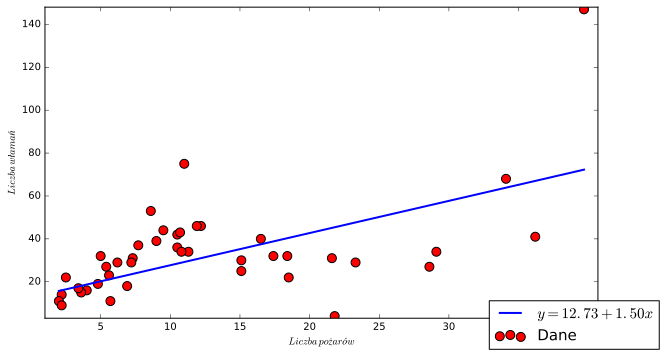

In [7]:
def first_task():
    x, y = read_from_file('fires_thefts.txt')
    fig = regdots(x, y)
    theta = [12.73, 1.5] 
    regline(fig, h, theta, x)
    legend(fig)

    display(Math(r'\Large \theta = ' + LatexMatrix(np.matrix(theta).reshape(2,1))))
    display(Math(r'\Large J(\theta) = %.4f' % J(h, theta, x, y)))
    
first_task()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

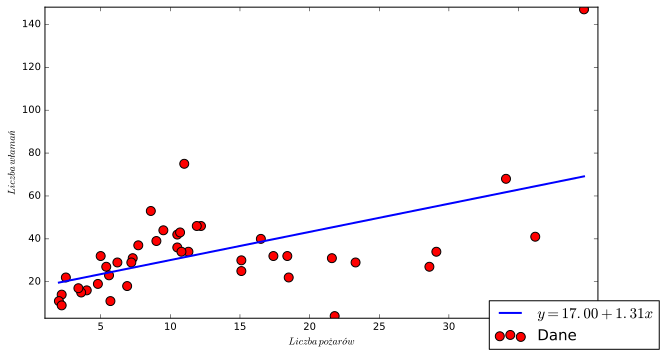

In [8]:
def second_task():
    XMx, yMx = read_from_file_matrix('fires_theft.txt')
    
    thetaNorm = norm(XMx, yMx)
    display(Math(r'\Large \theta = ' + LatexMatrix(thetaNorm)))
    display(Math(r'\Large J(\theta) = %.4f' % JMx(thetaNorm, XMx, yMx)))
    
    fig = regdotsMx(XMx, yMx)
    reglineMx(fig, hMx, thetaNorm, XMx)
    legend(fig)
    
second_task()

<IPython.core.display.Math object>

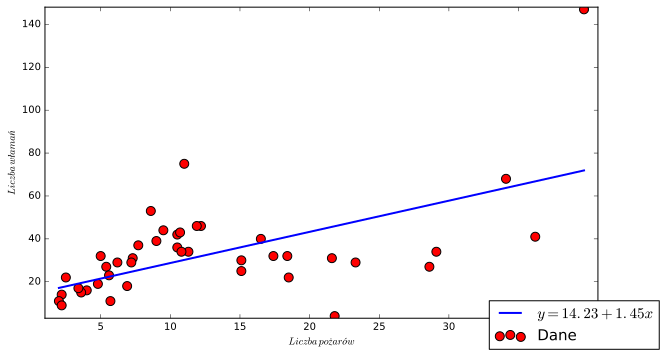

In [11]:
def third_task():
    XMx, yMx = read_from_file_matrix('fires_theft.txt')
    thetaStartMx = np.matrix([0,0]).reshape(2,1)

    thetaBestMx, errors = GDMx(JMx, dJMx, thetaStartMx, 
                               XMx, yMx, alpha=0.001, eps=10**-4)
    
    # Okazało się, że zaproponowany krok jest zbyt duży - wartość abs(errorPrev - errorCurr) rosła, zamiast maleć. 
    # Znaczy to, że krok należy zmniejszyć - dla dostatecznie małej wartości alpha otrzymujemy poprawne wyniki
    
    display(Math(r'\large\textrm{Wynik:}\quad \theta = ' + 
             LatexMatrix(thetaBestMx) + 
             (r' \quad J(\theta) = %.4f' % errors[-1][0])  
             + r' \quad \textrm{po %d iteracjach}' % len(errors)))
    
    fig = regdotsMx(XMx, yMx)
    reglineMx(fig, hMx, thetaBestMx, XMx)
    legend(fig)
    
third_task()

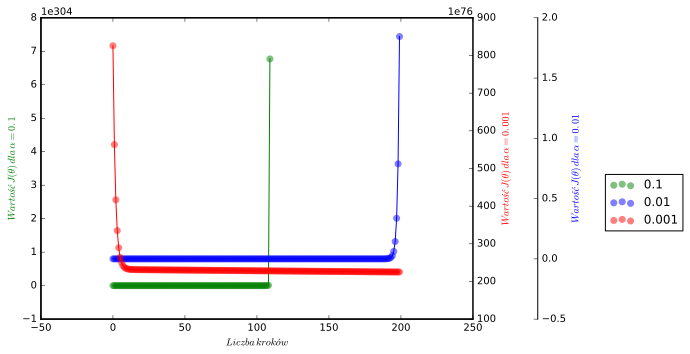

In [9]:
def fourth_task():
    XMx, yMx = read_from_file_matrix('fires_theft.txt')
    thetaStartMx = np.matrix([0,0]).reshape(2,1)
    x = np.arange(0, 200, 1)
    a = {0.001 : "red", 0.01 : "blue", 0.1: "green"}
    
    # poniżej dzieją się dziwne rzeczy, aby można narysować różne skale na tym samym wykresie :O
    fig = pl.figure(figsize=(16*.6,9*.6))
    ax = fig.add_subplot(111)
    axes = [ax, ax.twinx(), ax.twinx()]
    fig.subplots_adjust(right=0.75)
    axes[-2].spines['right'].set_position(('axes', 1.15))
    axes[-2].set_frame_on(True)
    axes[-2].patch.set_visible(False)
    
    # odtąd są już (chyba) całkiem normalne rzeczy
    props = dict(alpha=0.5, edgecolors='none')
    handles = []
    for elem in a:
        ax = axes[list(a.keys()).index(elem)]
        theta, errors = GDMx(JMx, dJMx, thetaStartMx, XMx, yMx, alpha=elem, eps=10**-4, limit=200)
        j_errors = np.array([errors[i][0] for i in range(len(errors))])
        handles.append(ax.scatter(x, j_errors, color=a[elem], label=elem, s=50, **props))
        ax.plot(x, j_errors, color=a[elem])
        ax.set_ylabel(r'$Wartość \, J(\theta) \, dla \, \alpha=%s$' % elem, color=a[elem])
        
    
    axes[0].set_xlabel(r'$Liczba \, kroków$')
    axes[0].legend(handles, [item for item in a], bbox_to_anchor=(1.5, 0.5))

fourth_task()

# Wyzwaniem w tym zadaniu było umieszczenie tych trzech krzywych na jednym wykresie ze względu na duży rostrzał między
# rzędem wielkości danych. Z tego względu każda krzywa otrzymała swoją własną skalę, mam nadzieję, że oznaczenia są czytelne.

# Tylko dla jednego z podanych parametrów alpha GD jest w stanie znaleźć minimum - jest to alpha=0.001, oznaczona kolorem
# czerwonym. Widać, że w miarę zwiększania liczby kroków, wartość J spada.
# Dla pozostałych dwóch wartości parametru alpha algorytm z każdą iteracją błądzi coraz bardziej po płaszczyźnie.
# Oznacza to, że krok jest zbyt duży i zamiast przybliżać się do minimum funkcji ksoztu, oddalamy się, nigdy do niego nie
# docierając. Jak widzimy na wykresie, dla alpha=0.01 (niebieski) wraz ze wzrostem liczby kroków rośnie wartość J. Identycznie
# jest w przypadku zielonej krzywej (0.1) - najpierw wartości nie przekraczają 1*10^304, a następnie gwałtownie rosną
# (na wykresie zaznaczono punkt, dla którego J przyjmuje wartość 6.77164486e+304, dla każdego kolejnego kroku numpy zwraca
# wartość jako "inf").

In [10]:
def fifth_task():
    XMx, yMx = read_from_file_matrix('fires_theft.txt')
    thetaNorm = norm(XMx, yMx)
    
    fires = [50, 100, 200]
    for fire in fires:
        theft = hMx(thetaNorm, np.matrix([1, fire]))
        print('W dzielnicy, w której występuje średnio %d pożarów na 1000 gospodarstw domowych ' \
              'można się spodziewać %f włamań na 1000 mieszkańców' % (fire, theft))
    
fifth_task()

W dzielnicy, w której występuje średnio 50 pożarów na 1000 gospodarstw domowych można się spodziewać 82.667957 włamań na 1000 mieszkańców
W dzielnicy, w której występuje średnio 100 pożarów na 1000 gospodarstw domowych można się spodziewać 148.340758 włamań na 1000 mieszkańców
W dzielnicy, w której występuje średnio 200 pożarów na 1000 gospodarstw domowych można się spodziewać 279.686358 włamań na 1000 mieszkańców
